In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [17]:
train_data = pd.read_csv("train_data.csv", sep='|')
train_bureau = pd.read_csv("train_bureau.csv", sep='|')

test_data = pd.read_csv("test_data.csv", sep='|')
test_bureau = pd.read_csv("test_bureau.csv", sep='|')


In [18]:
# train_data = train_data.drop('Top-up Month', axis=1)

In [19]:
cat_cols = list(train_data.select_dtypes('object').columns)
cat_cols

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Area',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'SEX',
 'City',
 'State',
 'Top-up Month']

In [20]:
for col in train_data.columns:
    if col not in cat_cols:
        print(col)

ID
BranchID
Tenure
AssetCost
AmountFinance
DisbursalAmount
EMI
AssetID
ManufacturerID
SupplierID
LTV
AGE
MonthlyIncome
ZiPCODE


In [21]:
train_data.isnull().sum()

ID                     0
Frequency              0
InstlmentMode          0
LoanStatus             0
PaymentMode            0
BranchID               0
Area               11653
Tenure                 0
AssetCost              0
AmountFinance          0
DisbursalAmount        0
EMI                    0
DisbursalDate          0
MaturityDAte           1
AuthDate               0
AssetID                0
ManufacturerID         0
SupplierID             0
LTV                    0
SEX                   59
AGE                   59
MonthlyIncome        234
City               11256
State                  0
ZiPCODE              372
Top-up Month           0
dtype: int64

In [22]:
test_data.isnull().sum()

ID                   0
Frequency            0
InstlmentMode        0
LoanStatus           0
PaymentMode          0
BranchID             0
Area               546
Tenure               0
AssetCost            0
AmountFinance        0
DisbursalAmount      0
EMI                  0
DisbursalDate        0
MaturityDAte         0
AuthDate             0
AssetID              0
ManufacturerID       2
SupplierID           0
LTV                  0
SEX                  5
AGE                  7
MonthlyIncome       14
City                 0
State                0
ZiPCODE              1
dtype: int64

In [23]:
for col in cat_cols:
    if col != 'Top-up Month':
        print(col)
        train_data[col] = train_data[col].fillna('UNK')
        test_data[col] = test_data[col].fillna('UNK')
        
        le = LabelEncoder()
        le.fit(list(train_data[col]) + list(test_data[col]))
        train_data[col] = le.transform(train_data[col])
        test_data[col] = le.transform(test_data[col])
        

Frequency
InstlmentMode
LoanStatus
PaymentMode
Area
DisbursalDate
MaturityDAte
AuthDate
SEX
City
State


In [24]:
for col in ['AGE', 'MonthlyIncome', 'ZiPCODE', 'ManufacturerID']:
    print(col)
    train_data[col] = train_data[col].fillna(-999)
    test_data[col] = test_data[col].fillna(-999)
    

AGE
MonthlyIncome
ZiPCODE
ManufacturerID


In [25]:
train_data['dataset_label'] = 0
test_data['dataset_label'] = 1

In [26]:
train_data.shape

(128655, 27)

In [27]:
test_data.shape

(14745, 26)

In [28]:
all_cols = list(train_data.columns)

In [29]:
def create_adversarial_data(df_train, df_test, cols, N_val=10000):
    df_master = pd.concat([df_train[cols], df_test[cols]], axis=0)
    adversarial_test = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_test.index)]
    return adversarial_train, adversarial_test

In [30]:
# adversarial_train, adversarial_test = create_adversarial_data(train_data, test_data, all_cols)
# adversarial_train.shape, adversarial_test.shape

In [31]:
from catboost import Pool, CatBoostClassifier

In [32]:
target = 'dataset_label'
features = list(set(all_cols) - set(['dataset_label']))

In [33]:
features

['AmountFinance',
 'EMI',
 'ZiPCODE',
 'ManufacturerID',
 'BranchID',
 'AuthDate',
 'Tenure',
 'ID',
 'State',
 'Frequency',
 'PaymentMode',
 'AssetCost',
 'AGE',
 'InstlmentMode',
 'MaturityDAte',
 'Top-up Month',
 'SEX',
 'LTV',
 'DisbursalDate',
 'City',
 'LoanStatus',
 'Area',
 'AssetID',
 'DisbursalAmount',
 'MonthlyIncome',
 'SupplierID']

In [34]:
cat_cols

['Frequency',
 'InstlmentMode',
 'LoanStatus',
 'PaymentMode',
 'Area',
 'DisbursalDate',
 'MaturityDAte',
 'AuthDate',
 'SEX',
 'City',
 'State',
 'Top-up Month']

In [35]:
# train_data = Pool(
#     data=adversarial_train[features],
#     label=adversarial_train[target],
# #     cat_features=cat_cols
# )
# holdout_data = Pool(
#     data=adversarial_test[features],
#     label=adversarial_test[target],
# #     cat_features=cat_cols
# )

In [36]:
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
#     'task_type': 'GPU', # if you have GPU
    'devices': '2', 
}

In [37]:
# model = CatBoostClassifier(**params)
# _ = model.fit(train_data, eval_set=holdout_data, plot=True, verbose=False)

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

In [40]:
# plot_roc(
#     [holdout_data.get_label()],
#     [model.predict_proba(holdout_data)[:,1]],
#     ['Baseline']
# )

In [41]:
import scipy.stats as stats
import shap
shap.initjs()

/home/shobhit/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [42]:
def plot_importances(model, holdout_data, features):
    explainer = shap.TreeExplainer(model)

    shap_values = model.get_feature_importance(holdout_data, type='ShapValues')
    expected_value = shap_values[0,-1]
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, holdout_data, feature_names=features, plot_type='bar')


In [43]:
#     plot_importances(model, holdout_data, features)

In [44]:
from sklearn.manifold import TSNE

In [53]:
features = [
#             'SupplierID', 
#             'DisbursalDate', 
            'LTV', 
            'MonthlyIncome', 
#             'BranchID', 
#             'AmountFinance', 
            'EMI', 
            'InstlmentMode', 
            'AGE', 
#             'ManufacturerID', 
#             'MaturityDAte', 
#             'ID', 
            'LoanStatus', 
#             'State', 
#             'Area', 
#             'ZiPCODE', 
            'Tenure', 
            'AssetCost', 
            'Frequency', 
            'DisbursalAmount', 
#             'AssetID', 
#             'City', 
            'PaymentMode', 
            'SEX', 
#             'AuthDate'
           ]

In [54]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_data[features])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 128655 samples in 0.336s...
[t-SNE] Computed neighbors for 128655 samples in 21.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 128655
[t-SNE] Computed conditional probabilities for sample 2000 / 128655
[t-SNE] Computed conditional probabilities for sample 3000 / 128655
[t-SNE] Computed conditional probabilities for sample 4000 / 128655
[t-SNE] Computed conditional probabilities for sample 5000 / 128655
[t-SNE] Computed conditional probabilities for sample 6000 / 128655
[t-SNE] Computed conditional probabilities for sample 7000 / 128655
[t-SNE] Computed conditional probabilities for sample 8000 / 128655
[t-SNE] Computed conditional probabilities for sample 9000 / 128655
[t-SNE] Computed conditional probabilities for sample 10000 / 128655
[t-SNE] Computed conditional probabilities for sample 11000 / 128655
[t-SNE] Computed conditional probabilities for sample 12000 / 128655
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 119000 / 128655
[t-SNE] Computed conditional probabilities for sample 120000 / 128655
[t-SNE] Computed conditional probabilities for sample 121000 / 128655
[t-SNE] Computed conditional probabilities for sample 122000 / 128655
[t-SNE] Computed conditional probabilities for sample 123000 / 128655
[t-SNE] Computed conditional probabilities for sample 124000 / 128655
[t-SNE] Computed conditional probabilities for sample 125000 / 128655
[t-SNE] Computed conditional probabilities for sample 126000 / 128655
[t-SNE] Computed conditional probabilities for sample 127000 / 128655
[t-SNE] Computed conditional probabilities for sample 128000 / 128655
[t-SNE] Computed conditional probabilities for sample 128655 / 128655
[t-SNE] Mean sigma: 130.210362
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.112640
[t-SNE] Error after 300 iterations: 5.361777


In [55]:
train_data['tsne-2d-one'] = tsne_results[:,0]
train_data['tsne-2d-two'] = tsne_results[:,1]

In [56]:
import seaborn as sns

In [57]:
train_raw = pd.read_csv("train_data.csv", sep='|')

In [58]:
train_data.columns

Index(['ID', 'Frequency', 'InstlmentMode', 'LoanStatus', 'PaymentMode',
       'BranchID', 'Area', 'Tenure', 'AssetCost', 'AmountFinance',
       'DisbursalAmount', 'EMI', 'DisbursalDate', 'MaturityDAte', 'AuthDate',
       'AssetID', 'ManufacturerID', 'SupplierID', 'LTV', 'SEX', 'AGE',
       'MonthlyIncome', 'City', 'State', 'ZiPCODE', 'Top-up Month',
       'dataset_label', 'tsne-2d-one', 'tsne-2d-two'],
      dtype='object')

In [59]:
# train_data['Top-up Month'] = train_raw['Top-up Month']

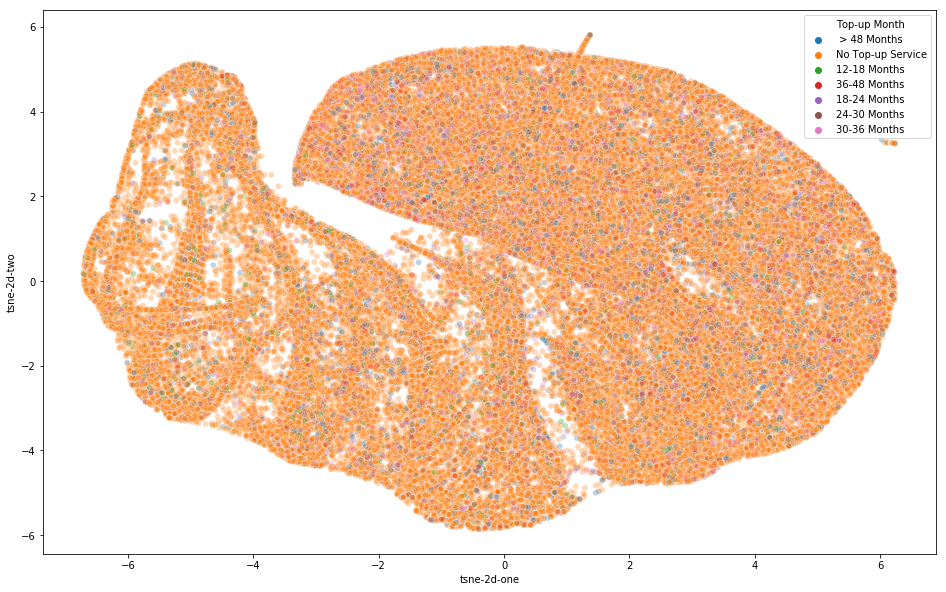

In [60]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Top-up Month",
#     palette=sns.color_palette("hls", 10),
    data=train_data,
    legend="full",
    alpha=0.3
)